# Titanic - Machine Learning from Disaster

## Data preprocessing

In [398]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [399]:
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
#check for null values
print(training_data.isnull().sum())
print(test_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Missing values in Age, Cabin and Embarked column in training data
Missing values in Age, Fare and Cabin column in test data
We can omit Cabin in our analysis as it is unlikely Cabin number has any causal effect on Survivability. Furthremore, Cabin number is likely based on Pclass which will cause perfect multicollinearity if we add it into the logistic regression model.

In [400]:
training_data = training_data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])
test_data = test_data.drop(columns=["Name", "Ticket", "Cabin"])

### Histogram of Age Grouped by Pclass

38.233440860215055

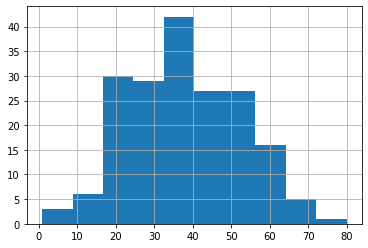

In [401]:
training_data[training_data["Pclass"] == 1]["Age"].hist()
training_data[training_data["Pclass"] == 1]["Age"].mean()

29.87763005780347

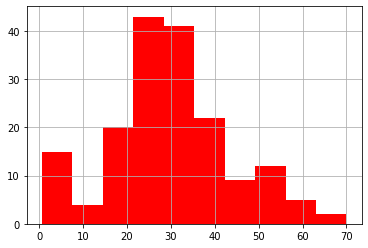

In [402]:
training_data[training_data["Pclass"] == 2]["Age"].hist(color = "red")
training_data[training_data["Pclass"] == 2]["Age"].mean()

25.14061971830986

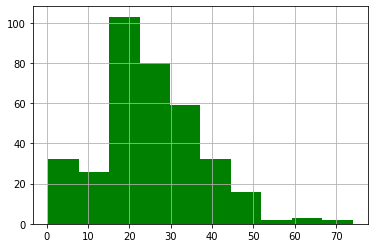

In [403]:
training_data[training_data["Pclass"] == 3]["Age"].hist(color = "green")
training_data[training_data["Pclass"] == 3]["Age"].mean()

Pclass is likely positively correlated with Age as an older person is more likely able to afford a higher class ticket. Therefore, we will fill in the missing Age values with means based on Pclass

In [404]:
def fill_missing_age(dataset):
    age = dataset[3]
    pclass = dataset[1]
    if pd.isnull(age):
            if pclass == 1:
                return 38
            elif pclass == 2:
                return 30
            else:
                return 25
    else:
        return age

In [405]:
training_data["Age"] = training_data.apply(fill_missing_age, axis=1)
test_data["Age"] = test_data.apply(fill_missing_age, axis=1)

### Dealing with Embarked missing values

<AxesSubplot:title={'center':'Bar chart of average fare grouped by Embarked'}, xlabel='Embarked', ylabel='Fare'>

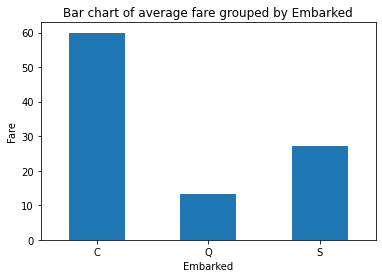

In [406]:
training_data.groupby(["Embarked"])["Fare"].mean().plot(kind = "bar", ylabel = "Fare", rot = 0, title = "Bar chart of average fare grouped by Embarked")

count    168.000000
mean      59.954144
std       83.912994
min        4.012500
25%       13.697950
50%       29.700000
75%       78.500025
max      512.329200
Name: Fare, dtype: float64

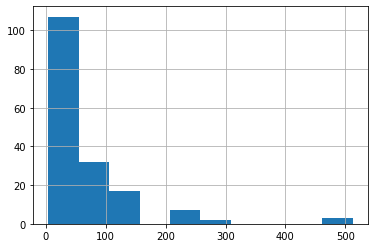

In [407]:
training_data[training_data["Embarked"] == "C"]["Fare"].hist()
training_data[training_data["Embarked"] == "C"]["Fare"].describe()

count    77.000000
mean     13.276030
std      14.188047
min       6.750000
25%       7.750000
50%       7.750000
75%      15.500000
max      90.000000
Name: Fare, dtype: float64

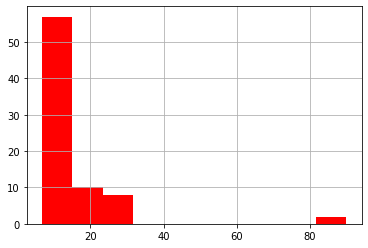

In [408]:
training_data[training_data["Embarked"] == "Q"]["Fare"].hist(color = 'red')
training_data[training_data["Embarked"] == "Q"]["Fare"].describe()

count    644.000000
mean      27.079812
std       35.887993
min        0.000000
25%        8.050000
50%       13.000000
75%       27.900000
max      263.000000
Name: Fare, dtype: float64

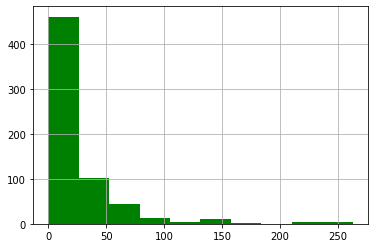

In [409]:
training_data[training_data["Embarked"] == "S"]["Fare"].hist(color = 'green')
training_data[training_data["Embarked"] == "S"]["Fare"].describe()

Embarked is most likely correlated with Fare as the location of where a passenger embarks likely determines the fare of ticket, considering all other variables remain constant. Therefore we will fill in missing embarked values based on ticket fare

In [410]:
def fill_missing_embarked(dataset):
    embarked = dataset[-1]
    fare = dataset[-2]
    if pd.isnull(embarked):
            if fare < 15.5:
                return "Q"
            elif 15.5 <= fare < 28:
                return "S"
            else:
                return "C"
    else:
        return embarked

def fill_missing_fare(dataset):
    embarked = dataset[-1]
    fare = dataset[-2]
    if pd.isnull(fare):
            if embarked == "Q":
                return 13.27
            elif embarked == "S":
                return 27.07
            else:
                return 59.95
    else:
        return fare

In [411]:
training_data["Embarked"] = training_data.apply(fill_missing_embarked, axis=1)
test_data["Fare"] = test_data.apply(fill_missing_fare, axis=1)
#training_data.isnull().sum()
test_data.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [412]:
y = training_data["Survived"].values
x = training_data[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]].values
x_test = test_data[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]].values

In [413]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#change sex and embarked to binary variables
x[:, 1] = le.fit_transform(x[:, 1])
x_test[:, 1] = le.transform(x_test[:, 1])
x[:, -1] = le.fit_transform(x[:, -1])
x_test[:, -1] = le.transform(x_test[:, -1])

In [414]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 1)

## Training data on logistic regression model

In [415]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train)

LogisticRegression()

In [416]:
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
y_pred = logistic_model.predict(x_valid)
cm = confusion_matrix(y_valid, y_pred)
print(cm)
accuracy_score(y_valid, y_pred)

[[90 16]
 [20 53]]


0.7988826815642458

In [417]:
y_test = logistic_model.predict(x_test)
submission = pd.DataFrame({'PassengerId': test_data['PassengerId'].values, 'Survived': y_test})
submission.to_csv("Titanic_Machine_learning.csv", index = False)